In [1]:
import tensorflow as tf
from modules.dataset import Dataset

2022-09-16 10:45:12.667657: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
train, test = Dataset().get_kfold(1, sample=True)
test

2022-09-16 10:45:17.476587: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-16 10:45:19.311896: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 32077 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:ca:00.0, compute capability: 8.0


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.int64, name=None))>

In [3]:
y_true=[]
for X,y in test:
    for label in y:
        y_true.append(label)
y_true = tf.Variable(y_true)
y_true

<tf.Variable 'Variable:0' shape=(200, 15) dtype=int64, numpy=
array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])>

In [6]:
# Constant variables
NAME = "ResNet50"
EPOCHS = 10
NUM_FOLDS = 5

dataset = Dataset()
fold_num = 1

# Dataset
train_dataset, test_dataset = dataset.get_kfold(fold_num, sample=True)

# Modeling
model = tf.keras.models.load_model("results/models/resnet50_fold1.h5")

ValueError: Unknown metric function: Addons>F1Score. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [10]:
y_preds = model.predict(test_dataset)

2022-09-16 09:54:36.662606: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-09-16 09:54:38.183255: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-16 09:54:38.184004: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-16 09:54:38.184022: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-09-16 09:54:38.184757: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-16 09:54:38.184807: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


      7/Unknown - 8s 29ms/step

2022-09-16 09:54:41.584425: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


13/13 [==============================] - 10s 177ms/step


In [8]:
(y_preds > 0.4).astype('int16')

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [9]:
y_preds

array([[0.48581904, 0.10406391, 0.03509307, ..., 0.07648436, 0.08108151,
        0.01197154],
       [0.48581904, 0.10406391, 0.03509307, ..., 0.07648436, 0.08108151,
        0.01197154],
       [0.48581904, 0.10406391, 0.03509307, ..., 0.07648436, 0.08108151,
        0.01197154],
       ...,
       [0.48581904, 0.10406391, 0.03509307, ..., 0.07648436, 0.08108151,
        0.01197154],
       [0.48581904, 0.10406391, 0.03509307, ..., 0.07648436, 0.08108151,
        0.01197154],
       [0.48581904, 0.10406391, 0.03509307, ..., 0.07648436, 0.08108151,
        0.01197154]], dtype=float32)

In [11]:
m = tf.keras.metrics.AUC(multi_label=True)
m.update_state(y_true, y_preds)
m.result().numpy()

0.5

In [ ]:
import inspect
inspect.getmembers(m)

In [141]:
""" Interesting Keys
>>* m._thresholds
>>> m._non_trainable_weights
>>> m._tracking_metadata
>>> m._unconditional_checkpoint_dependencies
>>* m._unconditional_dependency_names

>>* m.true_positives
>>* m.true_negatives
>>* m.false_positives
>>* m.false_negatives

>>* m.num_thresholds
>>* m.variables

for name,value in m._unconditional_checkpoint_dependencies:
    print(value.numpy())
"""

m.variables == list(m.weights)

True

In [165]:
for value, value_2 in zip(m.variables, [m.true_positives.numpy().tolist(), 
                                        m.true_negatives.numpy().tolist(),
                                        m.false_positives.numpy().tolist(),
                                        m.false_negatives.numpy().tolist()]):
    assert value.numpy().tolist() == value_2, "Not Equal"

## ROC

In [12]:
import tensorflow_addons as tfa

In [14]:
thresholds = m._thresholds
thresholds[:5]

array([-1.00000000e-07,  5.02512563e-03,  1.00502513e-02,  1.50753769e-02,
        2.01005025e-02])

In [62]:
m.variables

[<tf.Variable 'true_positives:0' shape=(200, 15) dtype=float32, numpy=
 array([[105.,  30.,   5., ...,  12.,  10.,   1.],
        [105.,  30.,   5., ...,  12.,  10.,   1.],
        [105.,  30.,   5., ...,  12.,  10.,   1.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]], dtype=float32)>,
 <tf.Variable 'true_negatives:0' shape=(200, 15) dtype=float32, numpy=
 array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [ 95., 170., 195., ..., 188., 190., 199.],
        [ 95., 170., 195., ..., 188., 190., 199.],
        [ 95., 170., 195., ..., 188., 190., 199.]], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(200, 15) dtype=float32, numpy=
 array([[ 95., 170., 195., ..., 188., 190., 199.],
        [ 95., 170., 195., ..., 188., 190., 199.],
        [ 

In [ ]:
true_positives, true_negatives, false_positives, false_negatives = m.variables
for i_thresh, (tps, tns, fps, fns) in enumerate(zip(true_positives, true_negatives, false_positives, false_negatives)):
    print(thresholds[i_thresh])
    for tp, tn, fp, fn in zip(tps, tns, fps, fns):
        print(tp, tn, fp, fn)
        break
    break

In [66]:
result.numpy()

array([[[  0.,  95.],
        [  0., 105.]],

       [[  0., 170.],
        [  0.,  30.]],

       [[  0., 195.],
        [  0.,   5.]],

       [[  0., 165.],
        [  0.,  35.]],

       [[  0., 189.],
        [  0.,  11.]],

       [[  0., 197.],
        [  0.,   3.]],

       [[  0., 199.],
        [  0.,   1.]],

       [[  0., 193.],
        [  0.,   7.]],

       [[  0., 177.],
        [  0.,  23.]],

       [[  0., 196.],
        [  0.,   4.]],

       [[  0., 188.],
        [  0.,  12.]],

       [[  0., 194.],
        [  0.,   6.]],

       [[  0., 188.],
        [  0.,  12.]],

       [[  0., 190.],
        [  0.,  10.]],

       [[  0., 199.],
        [  0.,   1.]]], dtype=float32)

In [53]:
import seaborn as sns
from modules.dataset import LABELS
import matplotlib.pyplot as plt

def plot_confusion_metics(confusion_metrics, threshold):
    fig = plt.figure(figsize=(35,20))
    fig.suptitle(f"Condusion Metrics for Threshold: {threshold}", fontsize=30)
    for i, confusion_metrix in enumerate(confusion_metrics.numpy().astype('int64')):
        plt.subplot(3, 5, i+1)
        plt.title(LABELS[i], fontweight='bold', fontsize=16)
        sns.heatmap(confusion_metrix, cbar=False, annot=True, fmt="d", cmap="Greens", linewidths=.5, annot_kws={"fontsize":24})
        plt.xlabel('"Prediction"', fontweight='bold')
        plt.ylabel('"Actual"', fontweight='bold')

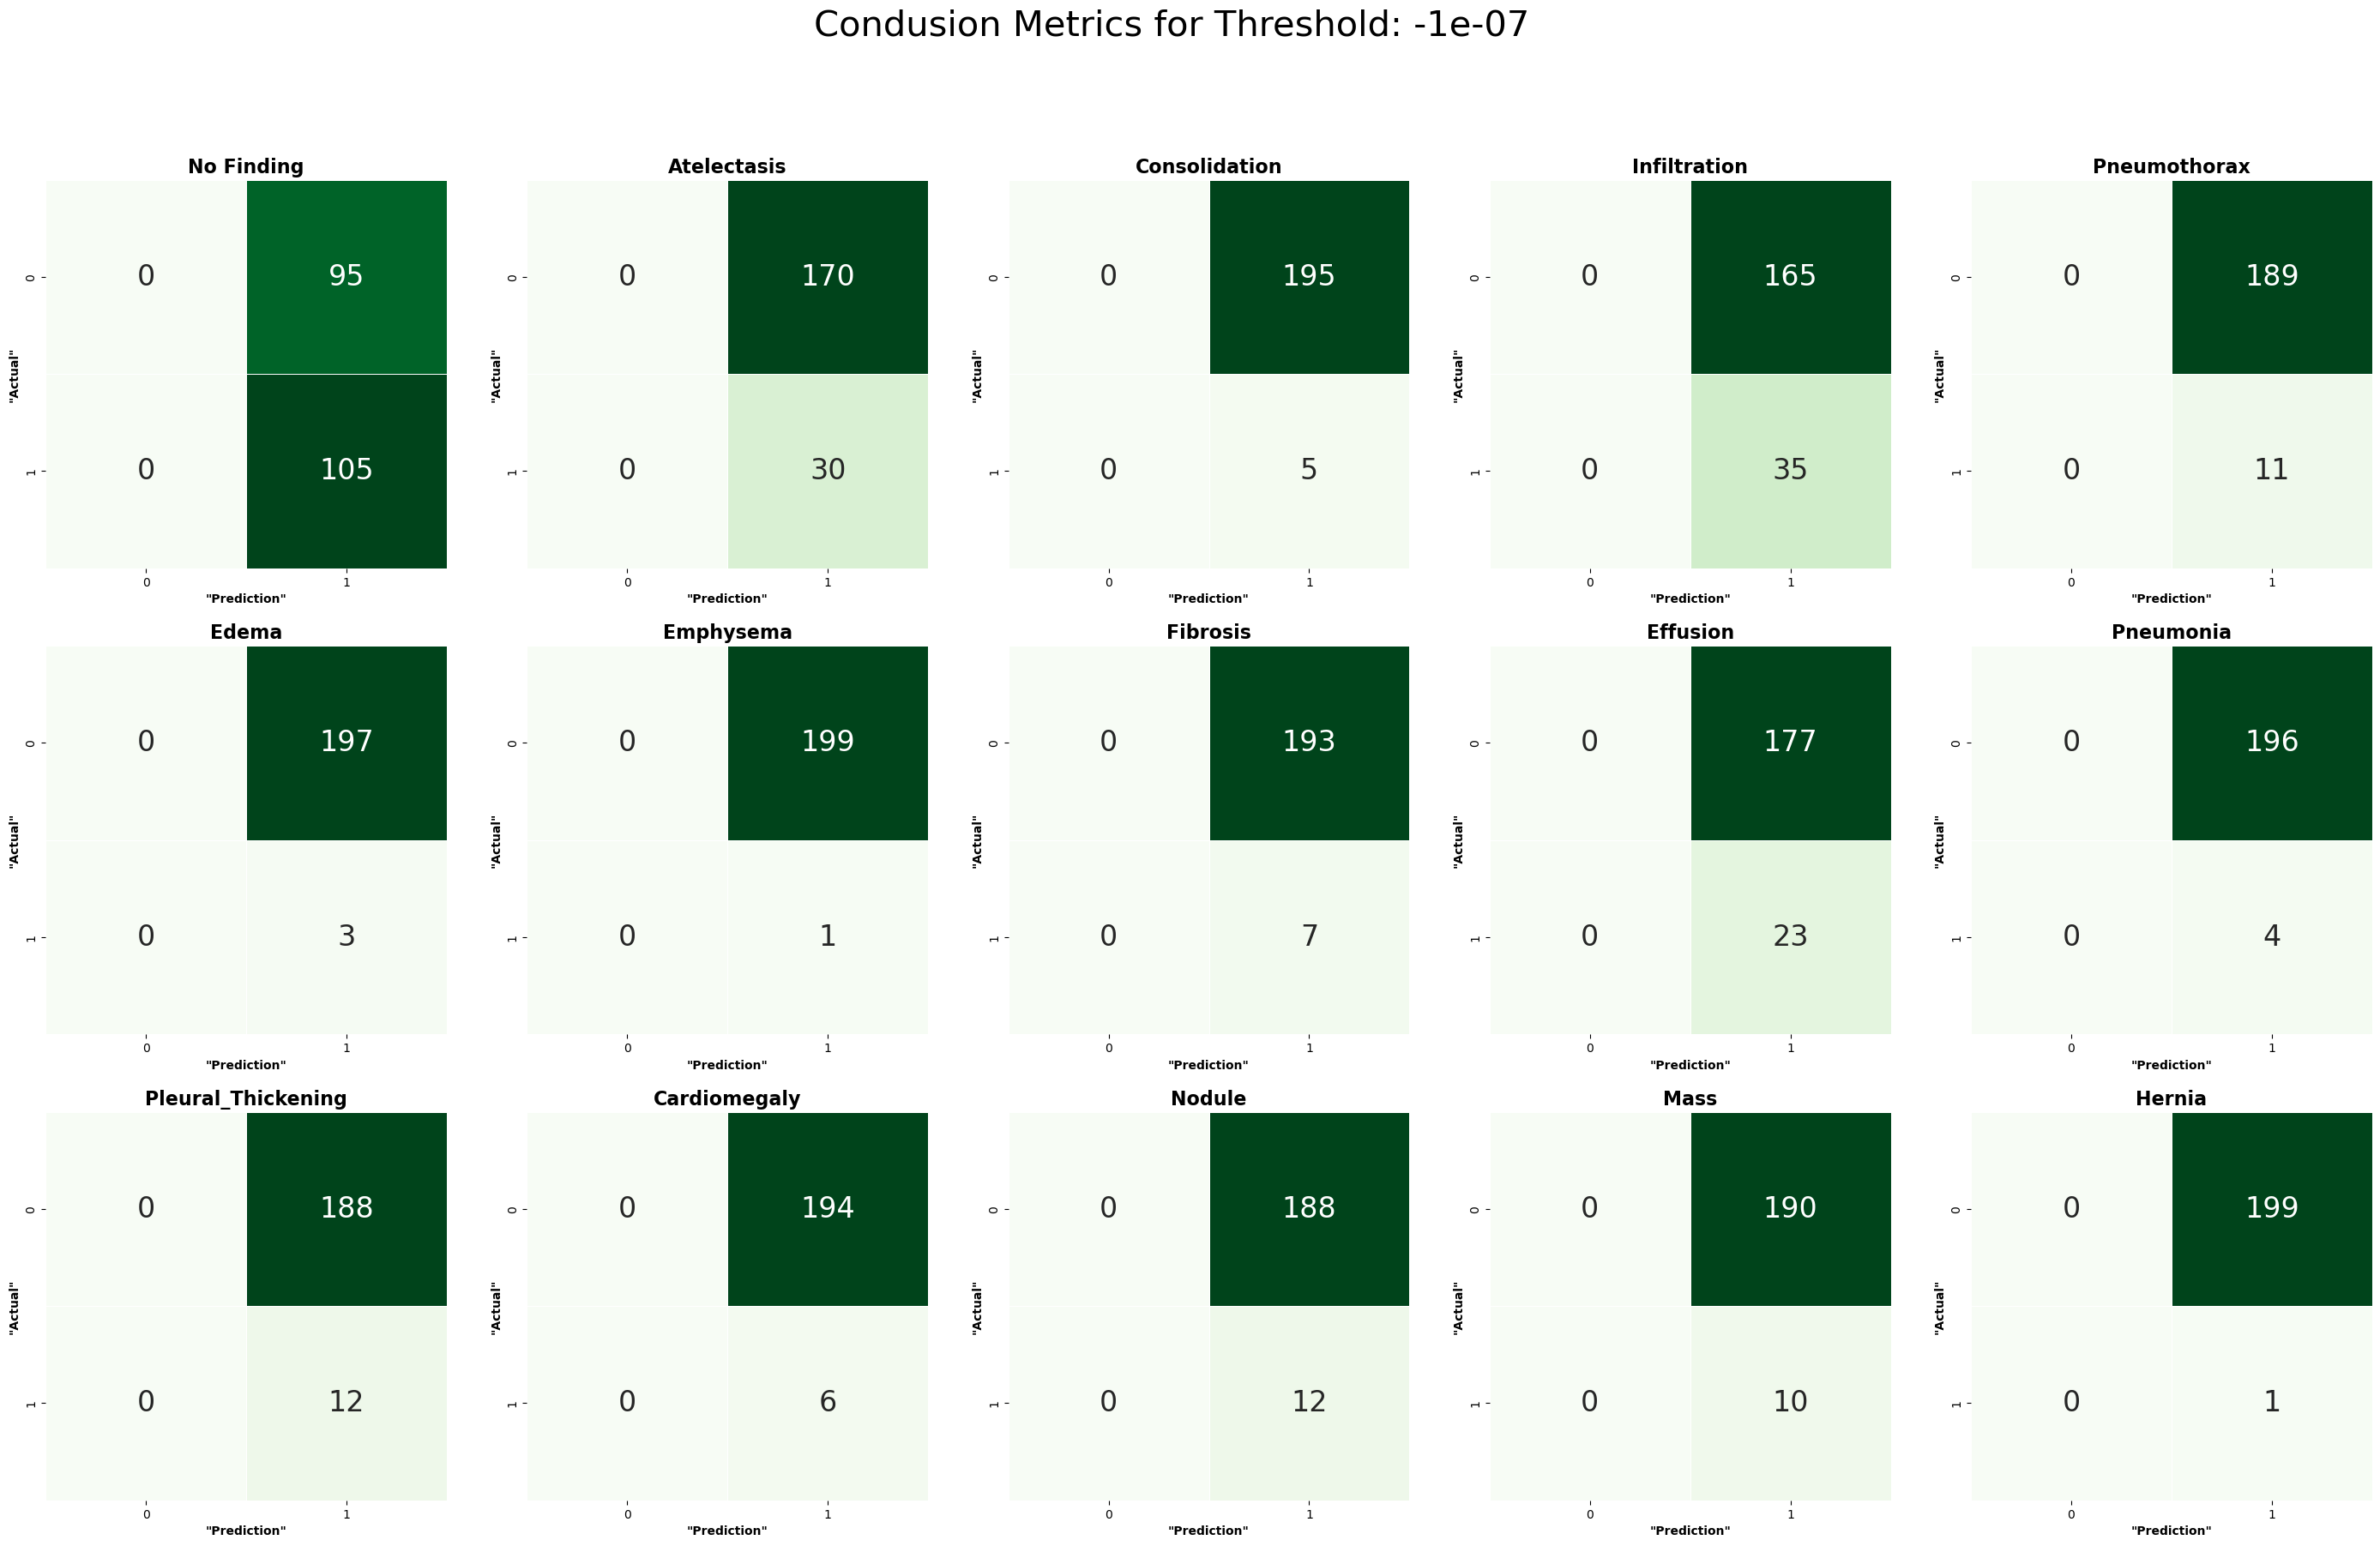

In [65]:
metric = tfa.metrics.MultiLabelConfusionMatrix(num_classes=15)
metric.update_state(y_true, 
                    (y_preds > thresholds[0]).astype('int8'))
result = metric.result()

plot_confusion_metics(result, thresholds[0])